# Data Pre-processing

In general, data pre-processing refers to the process of adding, removing or transforming a data set (train data). Frequently, the data preparation is essential for the performance of a predictive model.

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
sns.set()

# Loading the data

In [2]:
# reading the data set and filtering train
segData = pd.read_csv('../data/segData.csv')
segData = segData[segData.Case == 'Train']

In [3]:
# filtering id, class and case columns 
cellID = segData.Cell
cellClass = segData.Class
cellCase = segData.Case
segData = segData.drop(['Cell','Case','Class'], axis=1)

In [4]:
# filtering out status columns
segData = segData[[col for col in segData.columns if 'Status' not in col]]

# Skewness

An un-skewed distribution is one that is roughly symmetric. So the probability of falling on either side of the distribution's mean is roughly equal. Right-skewed distribution has a large number of points on the left side of the distribution.

One way to measure if a feature is  skewed is using the skewness statistic (https://en.wikipedia.org/wiki/Skewness). If the feature is symmetric the skewness is close do zero. If the feature distribution becomes more right skewed, the skewness statistic becomes larger. Also if the the distribution is left skewed the statistic becomes negative.

The reason to remove skewness is that some models assume normally distributed data and perform better with un-skewed distributions. 

One way to remove skewness is to apply Box-Cox transformation (https://en.wikipedia.org/wiki/Power_transform#Box.E2.80.93Cox_transformation. This method empirically identify an appropriate transformation. 

In [5]:
# measuring skewness of each column
skewValues = segData.skew()

In [6]:
skewValues[:10]

MorphologyV2Cell.AngleCh1                  -0.024335
MorphologyV2Cell.AreaCh1                    3.535613
MorphologyV2Cell.AvgIntenCh1                2.968004
MorphologyV2Cell.AvgIntenCh2                0.850688
MorphologyV2Cell.AvgIntenCh3                2.208905
MorphologyV2Cell.AvgIntenCh4                1.906135
MorphologyV2Cell.ConvexHullAreaRatioCh1     2.483962
MorphologyV2Cell.ConvexHullPerimRatioCh1   -1.307985
MorphologyV2Cell.DiffIntenDensityCh1        2.768700
MorphologyV2Cell.DiffIntenDensityCh3        2.091402
dtype: float64

Lets see some of the skewed distributions:

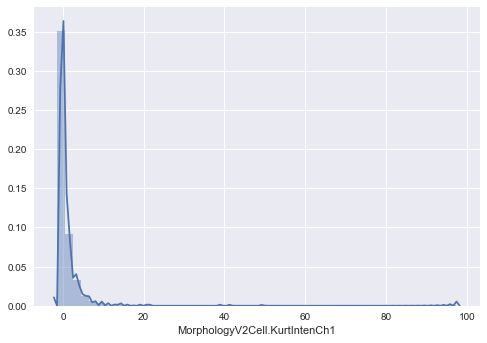

In [7]:
sns.distplot(segData['MorphologyV2Cell.KurtIntenCh1'])

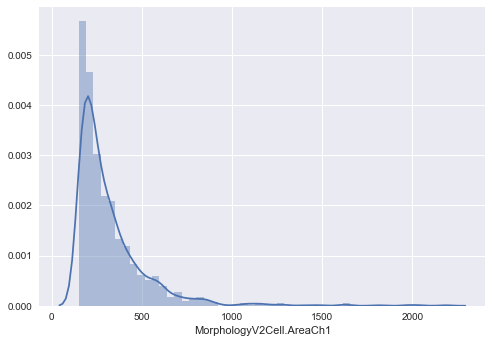

In [8]:
sns.distplot(segData['MorphologyV2Cell.AreaCh1'])

A more symmetric distribution:

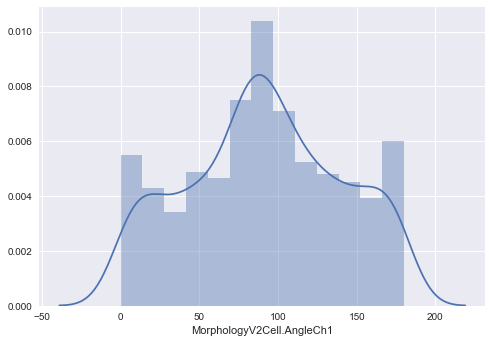

In [9]:
sns.distplot(segData['MorphologyV2Cell.AngleCh1'])

Let use Box-Cox transformation for fixing skewness of the second plot:

In [10]:
AreaCh1Trans, _ = stats.boxcox(segData['MorphologyV2Cell.AreaCh1'])

New distribution: 

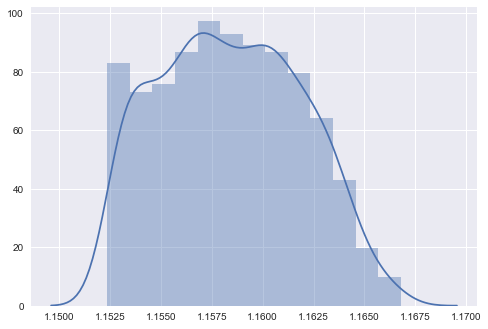

In [11]:
sns.distplot(AreaCh1Trans)

# Centering and Scaling

Centering a feature implies in subtracting from each feature value it's average. As a result the feature will have a zero mean.

Scaling means that each feature value is divided by it's standard deviation. So the feature have a standard deviation of one.

The process of centering and scaling are used to improve the numerical stability of some calculation. The downside is the loss of interpretability of the individual values since the data is no longer in the original units.

In [12]:
# centering and scale
from sklearn import preprocessing

In [13]:
segDataScaled =  preprocessing.scale(segData)

# Principal Components Analysis

Dimentionality reduction is the process of building a set of features smaller than the original that captures most of the information present in the original features.

Principal Components Analysis (PCA) is technique that tries to find a linear combination of the features. These components are the principal components and they capture most of the variance present in the data. The first component is the one that captures most of the variance of all possible linear combinations. The next components seek to capture the remaining variance and remain uncorrelated with the previous components.

PCA suffers of not pre-processed features. For example, features with a large range will dominate the first components (weights). So fix the skewness, scale and center the data. This will prevent the original feature unit of affecting the components.

In [14]:
from sklearn.decomposition import PCA

In [15]:
pca = PCA(n_components=10)

In [16]:
pca.fit(segDataScaled)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [17]:
print(pca.explained_variance_ratio_)

[ 0.20912359  0.170133    0.11886892  0.07715243  0.04957695  0.0412079
  0.03363512  0.03277417  0.02861985  0.02532366]


In [18]:
# loading vectors
print(pca.components_)

[[  1.21374446e-03   2.29171875e-01  -1.02708774e-01  -1.54828729e-01
   -5.80421577e-02  -1.17343445e-01   2.08230632e-01  -2.14316587e-01
   -1.01395189e-01  -4.69278273e-02  -1.11813371e-01  -6.51612521e-02
    5.55725006e-02  -6.65746765e-02   2.26096747e-01   1.09437897e-01
    2.33290591e-01   1.96721796e-01   2.29168268e-01   2.20440863e-01
   -1.50066527e-03  -1.13577603e-02   2.72399336e-01  -6.85194193e-02
   -5.53103712e-02   5.41617873e-02   8.09895171e-02  -2.42309877e-02
    7.44968984e-02  -5.93181492e-02  -5.56128563e-02   7.27877446e-02
    3.99604658e-02  -1.71774811e-03   6.11489357e-02   2.55946178e-01
    1.40373136e-02   7.33402268e-02  -1.24956624e-03   2.71152901e-01
   -1.76109782e-01   9.41234081e-02   2.31575249e-01   9.32279799e-02
   -7.94168271e-03   9.56527511e-02   1.60701237e-01   2.32054696e-01
    1.72614186e-03  -3.03913176e-02   5.91184469e-02  -1.22608200e-02
   -8.49330224e-02  -6.02468576e-02  -9.40061435e-02   1.92917712e-01
    7.02968470e-03  

Scree plot can be used to see how many componenets are responsible for most of the explained variance.

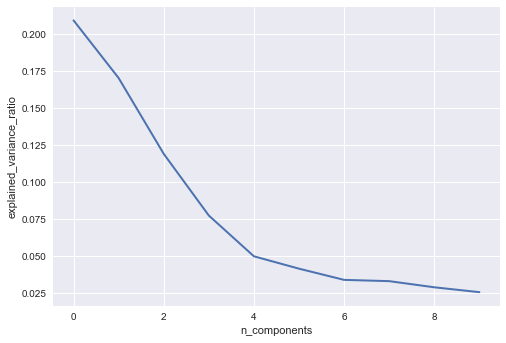

In [19]:
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio')

# Missing Data

Sometimes, some features have no value for a given instances. It's worth think about why there is missing values. The missing values could be strutural: such as the number of children a man has given birth. Or the values could not be determined at the time of the data extraction/modeling.

In other cases, the missing data may be related to the outcome. This is called informative missingness. For examples, patients suffering from side effects of a experimental drug may drop the study. Later this will represent important missing values.

It's more common to missing values to be associated with the features than the instances: concentrated in a few features than randomly across all the features. If the percentage of missing data is substantial, you may have to remove the feature.

When the missing values are associated with some instances and you have a large data set it's not a problem to remove them. However for small data sets this is not possible. To deal with this situation, you can use models that account for missing data or can do data imputation. Tree based models can deal with missing data.

For data imputation, you use the training set features to estimate the values of the other features. But remember that this procedure of adding a predicting inside another prediction increases the uncertainty of the overall model. One technique for imputation is the K-Nearest-Neighbor (KNN) model: an instance is imputed using the instances in the training data more close to it. The value imputed is the average of these closest points. However, for high dimensional data KNN may become computationally expensive. 

Scikit Learn provides a class Imputer with some strategies for data imputation: http://scikit-learn.org/stable/modules/preprocessing.html#imputation-of-missing-values

# Removing features

In some situations, removing features can be a useful for the modeling task. For example, if two features are highly corralated, this implies that they are measuring the same information (one of the features can be removed). Highly correlated features can result in numerical errors in linear regression models.

Also, one feature can have one unique value for all instances (zero variance feature). This feature gives no information about the class. Tree based models are not affected by these features. However, linear regression can be affected.

In [20]:
# calculate variance of all columns
segDataVariance = segData.var(axis=1)

In [21]:
segDataVariance.sort_values(inplace=True)

In [22]:
segDataVariance[:10]

121     196843.074260
1626    307549.970164
1587    314698.254093
1399    352584.022232
1840    415280.539203
1814    426822.118968
1676    521079.620504
1531    534949.534838
791     547410.109340
1613    577025.595386
dtype: float64

In [23]:
segDataCorrelation = segData.corr()

In [24]:
segDataCorrelation

,MorphologyV2Cell.AngleCh1,MorphologyV2Cell.AreaCh1,MorphologyV2Cell.AvgIntenCh1,MorphologyV2Cell.AvgIntenCh2,MorphologyV2Cell.AvgIntenCh3,MorphologyV2Cell.AvgIntenCh4,MorphologyV2Cell.ConvexHullAreaRatioCh1,MorphologyV2Cell.ConvexHullPerimRatioCh1,MorphologyV2Cell.DiffIntenDensityCh1,MorphologyV2Cell.DiffIntenDensityCh3,...,MorphologyV2Cell.TotalIntenCh1,MorphologyV2Cell.TotalIntenCh2,MorphologyV2Cell.TotalIntenCh3,MorphologyV2Cell.TotalIntenCh4,MorphologyV2Cell.VarIntenCh1,MorphologyV2Cell.VarIntenCh3,MorphologyV2Cell.VarIntenCh4,MorphologyV2Cell.WidthCh1,MorphologyV2Cell.XCentroid,MorphologyV2Cell.YCentroid
MorphologyV2Cell.AngleCh1,1.000000,-0.002627,-0.043008,-0.019447,-0.062484,-0.023841,-0.051612,0.041737,-0.074435,-0.071855,...,-0.011207,-0.009682,-0.043726,-0.030298,-0.049510,-0.057664,-0.042766,-0.053412,-0.056506,-0.055270
MorphologyV2Cell.AreaCh1,-0.002627,1.000000,-0.025297,-0.153303,-0.139352,-0.076807,0.328290,-0.476167,-0.063360,-0.139386,...,0.352110,0.346200,0.342010,0.333101,0.018524,-0.081639,-0.013108,0.842734,-0.033862,-0.110563
MorphologyV2Cell.AvgIntenCh1,-0.043008,-0.025297,1.000000,0.525217,0.273403,0.382298,-0.260242,0.324158,0.951805,0.227204,...,0.765743,0.461055,0.233257,0.329530,0.949776,0.325049,0.330558,-0.015126,-0.079986,-0.052917
MorphologyV2Cell.AvgIntenCh2,-0.019447,-0.153303,0.525217,1.000000,0.183599,0.573899,-0.470198,0.427990,0.496983,0.129433,...,0.296543,0.752793,0.116211,0.417847,0.467957,0.238624,0.549150,-0.080419,-0.030863,-0.035036
MorphologyV2Cell.AvgIntenCh3,-0.062484,-0.139352,0.273403,0.183599,1.000000,0.392865,0.026964,0.065719,0.436440,0.949635,...,0.127563,0.107168,0.775622,0.246838,0.357200,0.881594,0.382437,-0.090848,0.007231,0.007001
MorphologyV2Cell.AvgIntenCh4,-0.023841,-0.076807,0.382298,0.573899,0.392865,1.000000,-0.251133,0.243120,0.384892,0.315948,...,0.244360,0.484671,0.306767,0.799268,0.351488,0.334189,0.912824,0.004720,-0.033014,-0.015272
MorphologyV2Cell.ConvexHullAreaRatioCh1,-0.051612,0.328290,-0.260242,-0.470198,0.026964,-0.251133,1.000000,-0.703218,-0.211666,0.064039,...,-0.109398,-0.284373,0.203559,-0.109989,-0.209970,-0.038291,-0.200939,0.399328,0.042363,-0.054577
MorphologyV2Cell.ConvexHullPerimRatioCh1,0.041737,-0.476167,0.324158,0.427990,0.065719,0.243120,-0.703218,1.000000,0.275026,0.008142,...,0.106272,0.128854,-0.196205,0.029483,0.260669,0.073018,0.175448,-0.562149,-0.039101,0.000744
MorphologyV2Cell.DiffIntenDensityCh1,-0.074435,-0.063360,0.951805,0.496983,0.436440,0.384892,-0.211666,0.275026,1.000000,0.422895,...,0.692769,0.416540,0.345327,0.311097,0.955219,0.481944,0.342455,-0.048123,-0.071864,-0.030028
MorphologyV2Cell.DiffIntenDensityCh3,-0.071855,-0.139386,0.227204,0.129433,0.949635,0.315948,0.064039,0.008142,0.422895,1.000000,...,0.100288,0.063116,0.732358,0.188324,0.328229,0.894872,0.319024,-0.093268,0.013445,0.028834


Visualizing the correlation matrix:

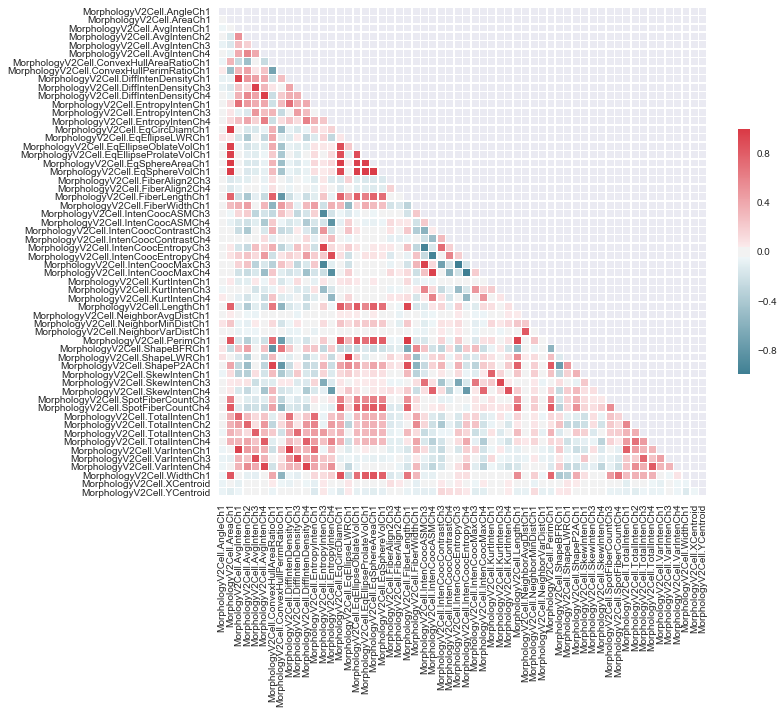

In [25]:
# Generate a mask for the upper triangle
mask = np.zeros_like(segDataCorrelation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(segDataCorrelation, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

# Removing highly correlated features

1. Calculate the correlation matrix
2. Select the two features with the greatest absolute correlation
3. Calculate the average correlation of these two features with all the other features
4. Remove the feature with the greatest average correlation
5. Repeat 2-5 until you meet a desired threshold

# Adding Predictors

It's common to decompose categorical features, gender or race for example, into a set of more specific variables. The feature Gender with values female and male can be re-encoded into two features Female and Male with values 0 or 1. This features are often called dummy variables.

The following example is from http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features

In [26]:
enc = preprocessing.OneHotEncoder()
enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
enc.transform([[0, 1, 3]]).toarray()

array([[ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]])